# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

## State Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram

#############
# Parameters
#############
# Using 2 qubits for testing (6 qubits for demonstration), scalable approach
num_qubits = 2
# Define the domain of the distribution,
# we only operate on the range [0, 10]
domain_min = 0
domain_max = 10
deductible = 1.0  # Deductible amount (amount of full retention)
coins = 0.4  # Coinsurance rate (% retained by the cedent)
# for rotation gates (paper says "a small value")
c_param = 0.25 / (domain_max - deductible) * 2

# Define lognormal distribution parameters
σ = 1.0  # Shape parameter
μ = 0.0     # Scale parameter

# Discretize domain into 2^num_qubits points
N = 2**num_qubits


def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, σ, loc=0, scale=np.exp(μ))


def lognormal_loss_discretized(domain_min, domain_max, N):
    """Lognormal loss function for discretized values"""
    # Take the midpoint integral approximation to work on small number of qubits
    mid_step = (domain_max - domain_min) / (N - 1)
    mid_x_vals = np.linspace(
        domain_min + mid_step / 2,
        domain_max - mid_step / 2,
        N
    )
    step = mid_x_vals[1] - mid_x_vals[0]
    probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
    probabilities /= probabilities.sum()

    return probabilities, mid_x_vals, step


probabilities, mid_x_vals, step = lognormal_loss_discretized(
    domain_min, domain_max, N)

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Display the first few amplitudes
print("First 10 amplitudes:")
for i in range(10):
    try:
        print(
            f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")
    except IndexError:
        pass

# Index of the first grid‑point *above* the deductible
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print('---------------------------')
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

First 10 amplitudes:
State |0⟩: √p_j = 0.884363, p_j = 0.782097
State |1⟩: √p_j = 0.389681, p_j = 0.151851
State |2⟩: √p_j = 0.217313, p_j = 0.047225
State |3⟩: √p_j = 0.137209, p_j = 0.018826
---------------------------
threshold = 0
binary threshold = 00


### Visualize State Preparation

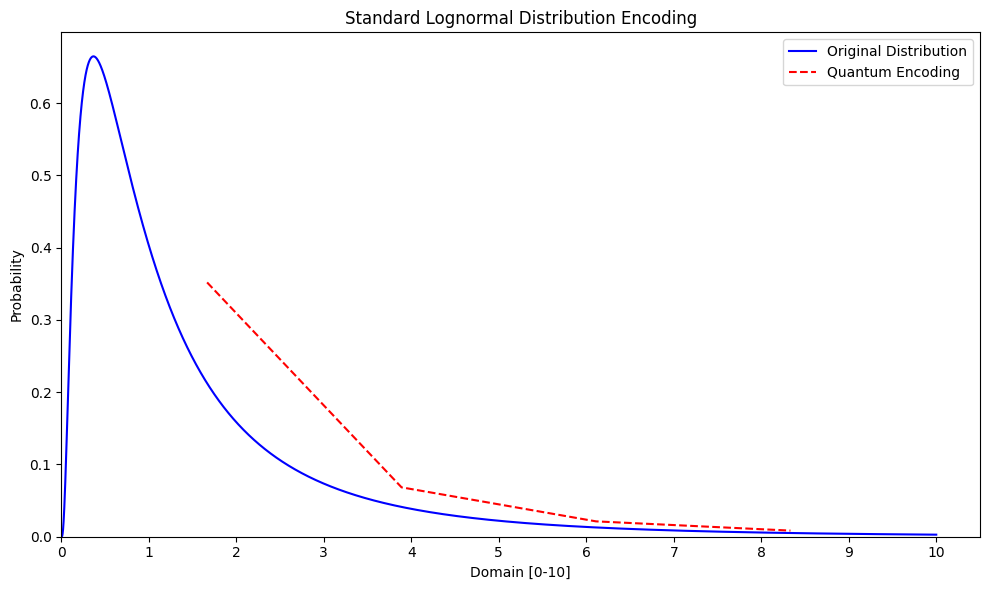

In [2]:
from qiskit_aer import Aer


# Create quantum circuit for state preparation
qc_state_prep = QuantumCircuit(num_qubits)
qc_state_prep.append(StatePreparation(amplitudes), range(num_qubits))

# Transpile the circuit to basic gates that Aer supports
qc_state_prep = transpile(qc_state_prep, basis_gates=['u3', 'cx'])

# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc_state_prep).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Create a "high resolution" distribution for comparison
high_res_probabilities, high_res_mid_x_vals, high_res_step = lognormal_loss_discretized(
    domain_min, domain_max, 10_000)

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(high_res_mid_x_vals, high_res_probabilities /
        high_res_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

### Compare State Degeneration by Resolution

C:\Users\alexf\AppData\Local\Temp\ipykernel_23712\3669596394.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)


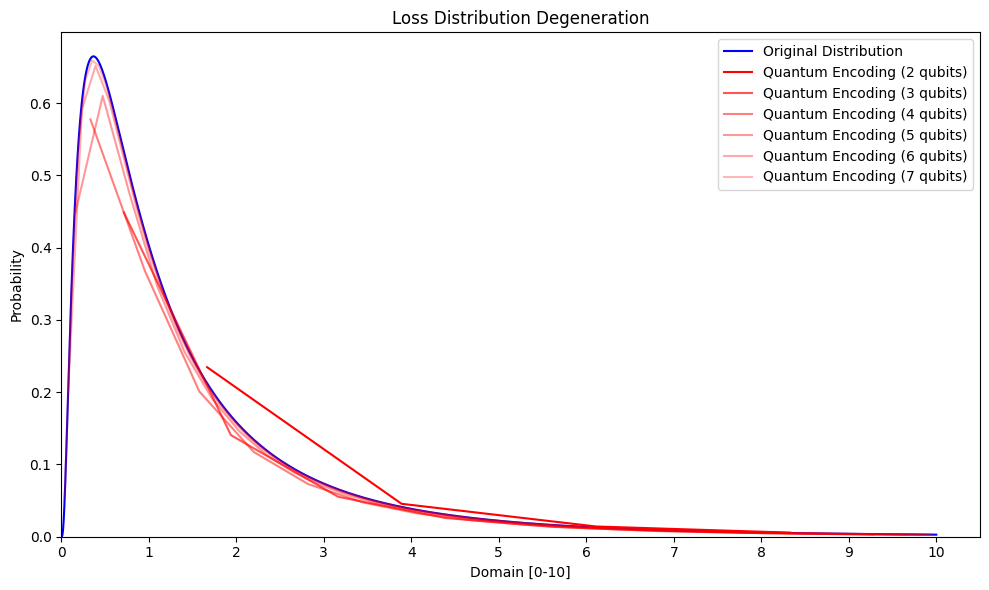

In [3]:
num_qubits_list = range(2, 8)
N_list = [2**n for n in num_qubits_list]
step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for step, N in zip(step_list, N_list)]
probabilities_list = []
for i, N in enumerate(N_list):
    x_vals = mid_x_vals_list[i]
    step = step_list[i]
    probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
    probabilities /= probabilities.sum()
    probabilities_list.append(probabilities)

# Add Color
cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(high_res_mid_x_vals, high_res_probabilities /
        high_res_step, 'b-', label='Original Distribution')
for i, N in enumerate(num_qubits_list):
    x_vals = mid_x_vals_list[i]
    step = step_list[i]
    probabilities = probabilities_list[i]
    alpha = 1/(i/2 + 1)
    plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Loss Distribution Degeneration')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

## Quantum Subtractor

In [4]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZGate, RYGate
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

def make_subtractor(loss_reg, constant) -> QuantumCircuit:
    """
    Quantum circuit that maps |x> -> |x - constant mod 2^n>
    on `loss_reg`.

    Parameters
    ----------
    loss_reg : QuantumRegister (or list of Qubits)
        Register that stores an unsigned integer.
    constant : int
        Positive integer < 2^n to subtract.
    """
    n  = len(loss_reg)
    qc = QuantumCircuit(loss_reg, name=f"-{constant}")

    # 1) Reverse into little-endian
    rev = loss_reg[::-1]

    # 2) QFT (decomposed → gate)
    qft_circ = QFT(num_qubits=n, do_swaps=False)
    qft_decomp = qft_circ.decompose()
    qft_decomp = transpile(qft_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    qft_gate   = qft_decomp.to_gate(label="QFT_decomp")
    qc.append(qft_gate, rev)

    # 3) Phase shift: subtract constant via phases
    for k, qb in enumerate(rev):
        angle = -2 * np.pi * constant / (2 ** (k + 1))
        qc.rz(angle, qb)

    # 4) Inverse QFT (decomposed → gate)
    inv_circ   = QFT(num_qubits=n, do_swaps=False).inverse()
    inv_decomp = inv_circ.decompose()
    inv_decomp = transpile(inv_decomp,
                            basis_gates=['u', 'cx'],
                            optimization_level=3)
    inv_gate = inv_decomp.to_gate(label="QFT_inv")
    qc.append(inv_gate, rev)

    # 5) Reverse back to MSB-first
    for i in range(n // 2):
        qc.swap(loss_reg[i], loss_reg[n - 1 - i])

    return qc

### Set up the Circuit

In [5]:
def add_payout_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "payout_aux") -> QuantumRegister:
    """
    Allocate ONE fresh qubit at the end of `qc`
    Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    Return the newly‑created QuantumRegister (length 1).
    """
    payout_aux = QuantumRegister(1, label)
    qc.add_register(payout_aux)
    # RY(π/2) on |0> → |+_y>
    # RY gate rotates the qubit around the Y axis
    # by an angle of π/2 radians (90 degrees).
    # This creates a superposition of |0> and |1> states
    # with equal probability amplitudes.
    # The resulting state is (|0> + |1>)/√2 = |+_y>
    qc.ry(np.pi / 2, payout_aux[0])
    return payout_aux


# 1) State-prep
x_q = QuantumRegister(num_qubits, "x") # loss register
qc  = QuantumCircuit(x_q) # create a new circuit
qc.append(StatePreparation(amplitudes), x_q) # state-prep circuit

# 2) Comparator → flag  (MSB→LSB)
flag_q = QuantumRegister(1, "flag") # flag for comparator
wcmp_q = QuantumRegister(num_qubits-1, "wcmp") # workspace for comparator
qc.add_register(flag_q, wcmp_q) # add registers to circuit

# Define the comparator gate (compare to a constant)
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# Append the comparator gate to the circuit
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# 3) QFT-subtractor (controlled on the same flag)
#   subtract threshold mod 2^n via phases in the QFT basis
sub_circ = make_subtractor(x_q, threshold_idx)
sub_gate = sub_circ.to_gate(label="qft_subtractor") # convert to gate
# Create a controlled version of the subtractor gate.
# The subtraction only happens if the single control qubit is in state |1>,
# leaving it unchanged otherwise.
csub_gate = sub_gate.control(1)
# Append the controlled subtractor gate to the circuit
qc.append(csub_gate, [flag_q[0]] + list(x_q))

# # 4) Process the excess
# # Ancilla qubits are extra qubits added to a quantum circuit
# # to facilitate certain operations or algorithms. 
# payout_aux = add_payout_qubit_and_bias(qc)

# # And encode the excess into the ancilla:
# for i, qb in enumerate(list(x_q)):
#     # The angle of the rotation is proportional to the excess
#     # and the qubit index (2^i).
#     angle = -2 * np.pi * c_param * (2**i)
#     # Build a 2-control RY(angle):
#     cry2 = RYGate(angle).control(2)         
#     # The first control is the flag, the second is the qubit.
#     qc.append(cry2, [flag_q[0], qb, payout_aux[0]])
    
#     # And the matching phase‐correction RZ(angle):
#     # Build a 2-control RZ(angle):
#     # The angle is the same as above.
#     # The first control is the flag, the second is the qubit.
#     crz2 = RZGate(angle).control(2)
#     qc.append(crz2, [flag_q[0], qb, payout_aux[0]])

# qc.draw(output='latex')

## Controlled Rotations

In [6]:
def _rotation_angle(excess_step, c):
    """Full angle θ for a controlled‑Ry so that P(1)=½ + c·excess_step."""
    Δ = c * excess_step  # how much we want to add to 0.5
    if np.abs(2 * Δ) > 1:
        raise ValueError("c·excess must keep |2θ| ≤ 1")
    return np.arcsin(2 * Δ)  # 2θ  because Qiskit RY takes the full angle


def apply_excess_rotations(
    qc: QuantumCircuit,
    excess_reg,
    flag_qubit,
    payout_qubit,
    step: float,
    c_param: float,
    little_endian: bool = False
) -> QuantumCircuit:
    """
    Apply controlled-RY rotations to the `payout_qubit` based on the
    `loss_reg` qubits. The rotations are controlled by the `flag_qubit`
    and are applied in the order of the qubits in `loss_reg`.

    Parameters:
    ----------
    qc : QuantumCircuit
        The quantum circuit to which the rotations will be added.
    excess_reg : QuantumRegister
        The quantum register holding the loss values.
    flag_qubit : Qubit
        The qubit that acts as the control for the rotations.
    payout_qubit : Qubit
        The qubit that will be rotated.
    step : float
        The step size for the rotations.
    c_param : float
        The parameter that determines the amount of rotation.
    little_endian : bool
        If True, the qubits are considered in little-endian order.
        If False, they are considered in big-endian order.
    """
    # Apply rotations directly based on each qubit's position (weight)
    for k, q in enumerate(excess_reg):
        # Calculate the excess value this bit position represents
        if little_endian:
            excess_value = (1 << k) * step
        else:
            excess_value = (1 << (len(excess_reg) - 1 - k)) * step

        # Calculate rotation angle - simpler calculation
        θ = _rotation_angle(excess_value, c_param)

        # Multi-Controlled-RY rotation
        # The mcry gate applies a controlled-RY rotation
        # to the target qubit (payout_qubit) based on the control qubits.
        # All the control qubits (flag_qubit and q) must be in the |1⟩ state.
        # Only rotate if flag is 1 (meaning value exceeds deductible)
        # AND this bit is 1 (contributes to excess)
        qc.mcry(
            θ,
            [flag_qubit, q],
            payout_qubit,
            None,
            mode='noancilla'
        )

    return qc

### Extend the Circuit

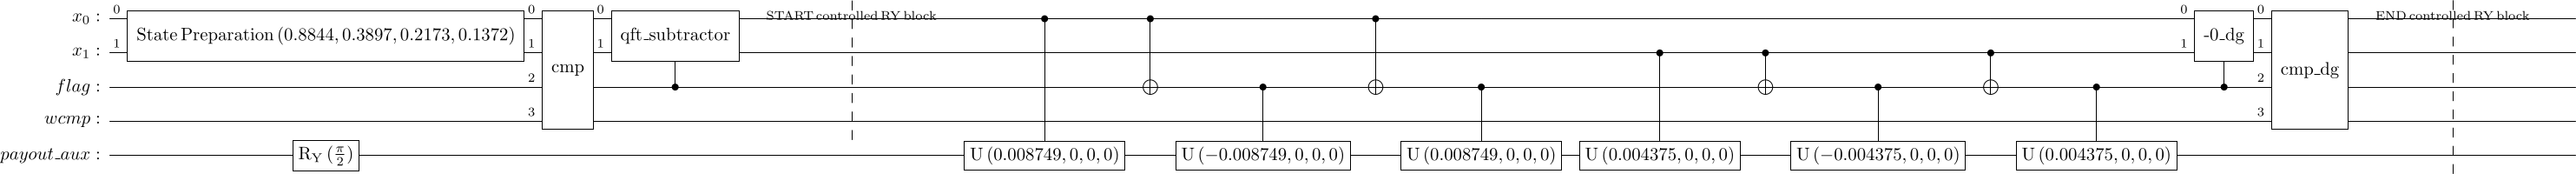

In [7]:
qc.barrier(label="START controlled RY block")

# 4) Process the excess
# Ancilla qubits are extra qubits added to a quantum circuit
# to facilitate certain operations or algorithms. 
payout_aux = add_payout_qubit_and_bias(qc)

# Apply Controlled-RY rotations, per the paper
qc = apply_excess_rotations(
    qc,
    excess_reg=x_q,
    flag_qubit=flag_q[0],
    payout_qubit=payout_aux[0],
    step=step,
    c_param=c_param,
    little_endian=False
)

# Uncompute the subtractor:
qc.append(csub_gate.inverse(), [flag_q[0]] + list(x_q))

# Uncompute the comparator:
qc.append(cmp_gate.inverse(), list(x_q) + [flag_q[0]] + list(wcmp_q))

# Add a barrier to separate the controlled RY block
# A barrier is a visual aid in quantum circuits
qc.barrier(label="END controlled RY block")

qc.draw(output='latex')

## [Simulated] Quantum Amplitude Estimation

In [8]:
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.primitives import Sampler
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit_aer import AerSimulator

# 1) Prepare the state‐prep circuit for Amplitude Estimation (AE)
qc_ae = qc.copy()
# remove final measurements
# this is needed to avoid errors when using the circuit in AE
qc_ae.remove_final_measurements()
qc_ae = qc_ae.decompose()  # decompose to basic gates
# Remove barriers and other non-quantum gates
qc_ae.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in qc_ae.data
    if inst.name != "barrier"
]

# Pick up the payout_aux index in the decomposed circuit
payout_aux_in_ae = qc_ae.qubits.index(payout_aux[0])

# 4) Build and run the EstimationProblem
# Convert circuits into pure unitary Gates so AE can add controls
state_prep_gate = qc_ae.to_gate(label="StatePrep")
state_prep_gate.num_ancillas = 0  # no ancillas
# A problem is a quantum circuit that prepares the state
problem = EstimationProblem(
    state_preparation=qc_ae,
    objective_qubits=[payout_aux_in_ae]
)
sampler = Sampler()  # Needed for AE to run, default is fine
ae = AmplitudeEstimation(
    num_eval_qubits=3,  # 3 is the default, more is slower but more accurate
    sampler=sampler)
result = ae.estimate(problem)  # run AE

# 5) Compute and print the payout
# p_hat = result.estimation
# excess = (p_hat - 0.5)/c_param
# payout = excess * coins

# print(f"quantum payout = {payout}")

# result.estimation doesn't pick up the rotation,
# but the confidence interval does.
# Calculate the mean of confidence interval as a potentially more accurate estimate
ci_mean = (result.confidence_interval[0] + result.confidence_interval[1]) / 2

# Print results
print("\nAmplitude Estimation Results:")
print(f"QAE p_hat: {result.estimation:.6f}")
print(
    f"QAE confidence interval: [{result.confidence_interval[0]:.6f}, {result.confidence_interval[1]:.6f}]")
print(f"CI mean: {ci_mean:.6f}")
excess = (ci_mean - 0.5) / c_param
print(f"QAE excess (from CI mean): {excess:.6f}")
print(f"QAE payout (from CI mean): {(1 - coins) * excess:.6f}")

C:\Users\alexf\AppData\Local\Temp\ipykernel_23712\915728901.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc_ae.data
C:\Users\alexf\AppData\Local\Temp\ipykernel_23712\915728901.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()  # Needed for AE to run, default is fine



Amplitude Estimation Results:
QAE p_hat: 0.500000
QAE confidence interval: [0.501324, 0.501324]
CI mean: 0.501324
QAE excess (from CI mean): 0.023841
QAE payout (from CI mean): 0.014304


## Classical Monte Carlo

In [9]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(σ, loc=0, scale=np.exp(μ))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - (1 - coins) * (lnorm - deductible) - deductible
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - (1 - coins) * (lnorm_0_10 - deductible) - deductible
    cmc_results_0_10[i] = payout_0_10


C:\Users\alexf\AppData\Local\Temp\ipykernel_23712\775231159.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


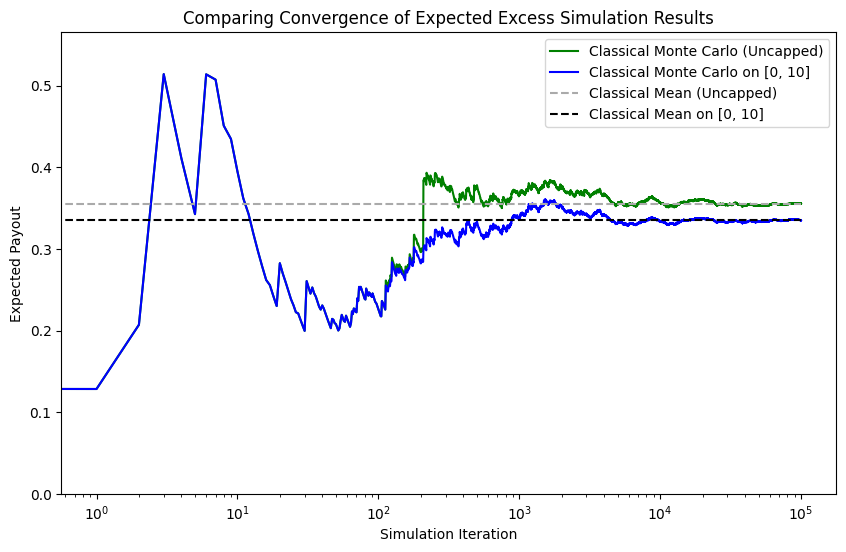

In [10]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean[-1], xmin=0, xmax=cmc_samples, color='#aaaaaa', linestyle='--', label='Classical Mean (Uncapped)')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Classical Mean on [0, 10]')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 1.1 * max(np.max(cmc_running_mean), np.max(cmc_running_mean_0_10)))
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

In [11]:
print(f"Classical Mean (Uncapped) = {cmc_running_mean[-1]}")
print(f"Classical Mean on [0, 10] = {cmc_running_mean_0_10[-1]}")

Classical Mean (Uncapped) = 0.3555006436015467
Classical Mean on [0, 10] = 0.33510317755969515


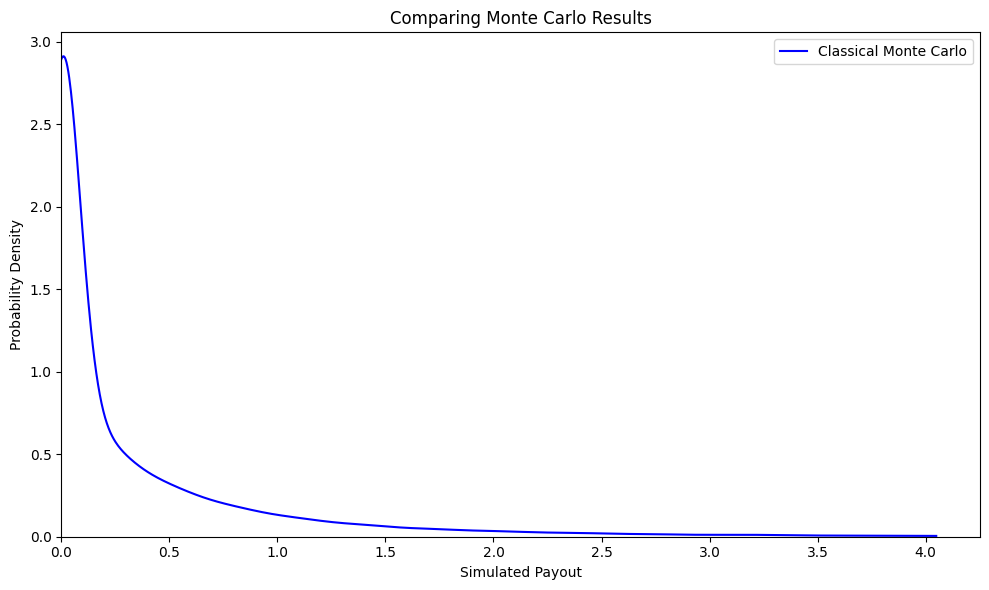

In [12]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()